# Fitting Level 1 EIS Spectra with NDCube and Astropy Models

Notebook adapted from https://gist.github.com/wtbarnes/7011b1c989776db168dee8b1ea829519

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import ndcube
import astropy.units as u
import astropy.wcs
from astropy.modeling import models, fitting
import astropy.constants as const
import sunpy.map
from astropy.visualization import ImageNormalize, LogStretch, quantity_support

In this notebook, we'll demonstrate how to load the level 1 EIS spectra into an NDCube and fit each spectra using a compound Astropy model

First, define a function that loads the level 1 data cubes from HDF5 into an NDCube

In [2]:
def eis_lev1_to_ndcube(filename_data, filename_meta, window): 
    # Read data 
    with h5py.File(filename_data, 'r') as hf: 
        data = np.array(hf[f'level1/win{window:02d}']) 
    # Read metadata 
    with h5py.File(filename_meta, 'r') as hf: 
        meta = {k: hf[f'index/{k}'][0] for k in hf['index'].keys()} 
        meta_pointing = {k: hf[f'pointing/{k}'][0] for k in hf['pointing'].keys()} 
        wavelength = hf[f'wavelength/win{window:02d}'][:] 
        wavelength_correction = hf['wavelength/wave_corr'][:] 
        response = hf[f'radcal/win{window:02d}_pre'][:] 
    # Format header correctly 
    meta.update(meta_pointing) 
    meta['ctype1'] = 'HPLN-TAN' 
    meta['ctype2'] = 'HPLT-TAN' 
    meta['ctype3'] = 'WAVE' 
    meta['cdelt1'] = meta['x_scale'] 
    meta['cdelt2'] = meta['y_scale'] 
    meta['naxis1'] = data.shape[1] 
    meta['naxis2'] = data.shape[0] 
    meta['crpix3'] = 1 
    meta['crval3'] = wavelength[0] 
    meta['cdelt3'] = np.diff(wavelength)[0]  # This is not quite correct, close enough for now 
    meta['naxis3'] = wavelength.shape[0] 
    for k,v in meta.items(): 
        if isinstance(v, np.bytes_):
            meta[k] = v.decode('utf-8')
    # Make WCS
    wcs_keys = [
        'crpix1',
        'crval1',
        'cdelt1',
        'ctype1',
        'naxis1',
        'cunit1',
        'crpix2',
        'crval2',
        'cdelt2',
        'ctype2',
        'naxis2',
        'cunit2',
        'crpix3',
        'crval3',
        'cdelt3',
        'ctype3',
        'naxis3',
        'cunit3',
    ]
    wcs = astropy.wcs.WCS({k: meta[k] for k in wcs_keys})
    # Handle bad data and uncertainties
    data = np.swapaxes(np.swapaxes(data * response, 0, 2), 1, 2)
    data = u.Quantity(data, 'erg / (cm2 s sr)')
    # FIXME: better ways to do the uncertainty
    uncertainty = u.Quantity(np.sqrt(data.value), data.unit)
    cube = ndcube.NDCube(data,
                         wcs,
                         meta=meta,
                         mask=data < 0*data.unit,
                         uncertainty=uncertainty.value,)
    # FIXME: better way to attach this info than just a separate 2D cube?
    wavelength_correction = ndcube.NDCube(
        wavelength_correction,
        wcs,
        meta=meta,
        unit=meta['cunit3']
    )
    return cube, wavelength_correction

Now, load the data for one of our sample datasets

In [3]:
cube, wave_correction = eis_lev1_to_ndcube('data/eis_20190404_131513.data.h5',
                                           'data/eis_20190404_131513.head.h5', 7)

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


/tmp/ipykernel_149092/1789730461.py:54: RuntimeWarning: invalid value encountered in sqrt
  uncertainty = u.Quantity(np.sqrt(data.value), data.unit)


We can plot a single slice from the cube

<WCSAxes: >

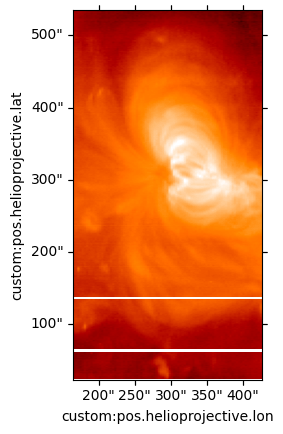

In [4]:
cube[12,:,:].plot(
    aspect=cube.meta['cdelt2']/cube.meta['cdelt1'],
    cmap='hinodexrt',
    norm=ImageNormalize(vmin=1e2,vmax=3e4,stretch=LogStretch())
)

We can also slice out a single spectra along a given pixel

In [5]:
spec_1d = cube[:, 100, 10]

<WCSAxes: ylabel='Data [erg / (s sr cm2)]'>

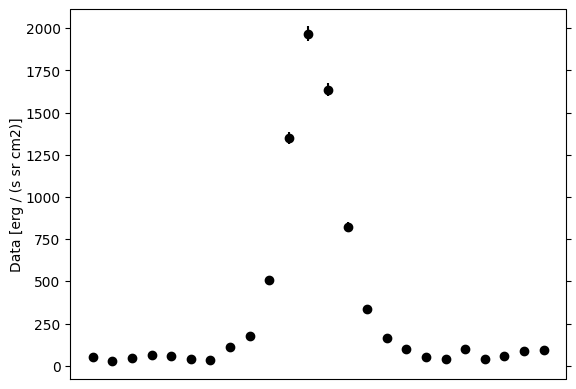

In [6]:
spec_1d.plot(ls='',marker='o',color='k')

We can use the `astropy.modeling` framework to fit this spectra. A few fit templates have already been defined for MPFIT and these templates are stored in the accompanying HDF5 files. Let's convert one of these fit templates into an astropy model.

First, load the MPFIT template


This represents a double-Gaussian fit with a constant background. We can build an equivalent compound astropy model. This corresponds to the Fe XII lines at 195.119 and 195.179 angstroms

In [7]:
g1 = models.Gaussian1D(amplitude=2000, mean=195.1179, stddev=0.0289)
g2 = models.Gaussian1D(amplitude=10000, mean=195.1779, stddev=0.0289)
bg = models.Polynomial1D(degree=0, c0=664.3349)
# g1 = models.Gaussian1D(amplitude=57514.6647, mean=195.1179, stddev=0.0289)
# g2 = models.Gaussian1D(amplitude=8013.4013, mean=195.1779, stddev=0.0289)
# bg = models.Polynomial1D(degree=0, c0=664.3349)

Next, we can bound each set of parameters appropriately based on the values in the fit template file

In [8]:
g1.amplitude.bounds = (0, 100000000000)
g1.mean.bounds = (195.0778, 195.1581)
g1.stddev.bounds = (0.0191, 0.0510)
g2.amplitude.bounds = (0, 100000000000)
g2.mean.bounds = (195.1378, 195.2181)
g2.stddev.bounds = (0.0191, 0.0510)

Finally, we can apply the "tied" constraints

In [9]:
def tie_rest_wavelengths(model):
    return model.mean_0 + 0.06

g2.mean.tied = tie_rest_wavelengths

def tie_widths(model):
    return model.stddev_0

g2.stddev.tied = tie_widths

And create our compound, constrained model

In [10]:
fe12_model = g1 + g2 + bg

Let's fit our 1D spectra using this model.

In [11]:
spec_1d.axis_world_coords('em.wl')

(<SpectralCoord [1.94859018e-08, 1.94881303e-08, 1.94903587e-08, 1.94925872e-08,
    1.94948156e-08, 1.94970440e-08, 1.94992725e-08, 1.95015009e-08,
    1.95037294e-08, 1.95059578e-08, 1.95081863e-08, 1.95104147e-08,
    1.95126431e-08, 1.95148716e-08, 1.95171000e-08, 1.95193285e-08,
    1.95215569e-08, 1.95237854e-08, 1.95260138e-08, 1.95282422e-08,
    1.95304707e-08, 1.95326991e-08, 1.95349276e-08, 1.95371560e-08] m>,)

In [12]:
wavelength_corrected = spec_1d.axis_world_coords('em.wl')[0] - wave_correction.data[326,48]*wave_correction.unit

In [13]:
wavelength_corrected = wavelength_corrected.to(u.AA)

In [14]:
w = np.linspace(*wavelength_corrected[[0,-1]].value,500)*wavelength_corrected.unit

In [15]:
fitter = fitting.LevMarLSQFitter()

In [16]:
fitted_model = fitter(fe12_model,
                      wavelength_corrected,
                      spec_1d.data*spec_1d.unit,
                      weights=1/spec_1d.uncertainty.array,
                      acc=1e-8,
                      maxiter=10000
                      )

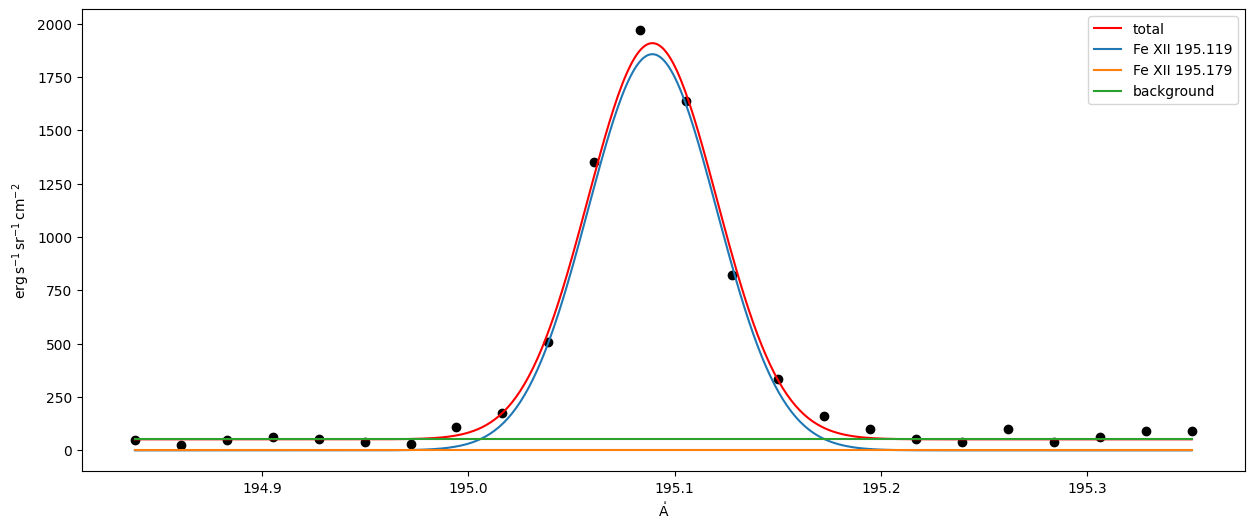

In [17]:
with quantity_support():
    fig = plt.figure(figsize=(15,6))
    ax = fig.gca()
    ax.plot(wavelength_corrected, spec_1d.data*spec_1d.unit, ls='', marker='o', color='k')
    ax.plot(w, fitted_model(w), ls='-',color='r', label='total')
    ax.plot(w, fitted_model[0](w), ls='-', color='C0', label='Fe XII 195.119')
    ax.plot(w, fitted_model[1](w), ls='-', color='C1', label='Fe XII 195.179')
    ax.plot(w, fitted_model[2](w), ls='-', color='C2', label='background')
    ax.legend()

Finally, let's try to fit every pixel:

In [18]:
fe12_model.fixed

{'amplitude_0': False, 'mean_0': False, 'stddev_0': False, 'amplitude_1': False, 'mean_1': False, 'stddev_1': False, 'c0_2': False}

In [19]:
from astropy.modeling import CompoundModel

In [20]:
fe12_model

<CompoundModel(amplitude_0=2000., mean_0=195.1179, stddev_0=0.0289, amplitude_1=10000., mean_1=195.1779, stddev_1=0.0289, c0_2=664.3349)>

In [21]:
from tqdm.dask import TqdmCallback

from astropy.modeling.fitting_parallel import parallel_fit_model_nd

with TqdmCallback(desc="fitting"):

    fe12_model_fit = parallel_fit_model_nd(
        model=fe12_model,
        fitter=fitter,
        data=cube.data,
        fitting_axes=0,
        world = {0: wavelength_corrected},
        # diagnostics="failed",
        # diagnostics_path="diag",
    )

fitting:   0%|          | 0/1529 [00:00<?, ?it/s]

Process SpawnProcess-16:
Process SpawnProcess-11:
Process SpawnProcess-7:
Process SpawnProcess-9:
Process SpawnProcess-4:
Process SpawnProcess-3:
Process SpawnProcess-6:
Process SpawnProcess-15:
Process SpawnProcess-5:
Process SpawnProcess-10:
Process SpawnProcess-14:
Process SpawnProcess-8:
Process SpawnProcess-12:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.12/concurrent/futures/process.py", line 251, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 102, in get
    with self._rlock:
  File "/usr/lib/python3.12/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
Keyb

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(15, 5))
for ipar, name in enumerate(fe12_model_fit.param_names):
    ax = fig.add_subplot(1, 7, ipar + 1)
    array = getattr(fe12_model_fit, name)
    ax.imshow(array, vmin=np.percentile(array, 1), vmax=np.percentile(array, 99),
              aspect=cube.meta['cdelt2']/cube.meta['cdelt1'], origin='lower')
    ax.set_title(name)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)